In [14]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the directory containing the dataset
dataset_dir = "dataset_coba3"

In [4]:
# Define the desired number of samples per class
desired_samples_per_class = 15000

# Load and preprocess the dataset
images = []
labels = []

# Determine the number of photos per class
class_counts = {}
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    class_counts[label] = len(os.listdir(label_dir))
num_photos_per_class = min(class_counts.values())

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

label_encoder = LabelEncoder()
label_encoder.fit(os.listdir(dataset_dir))  # Fit the label encoder to the label names

for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    num_generated_samples = 0
    while num_generated_samples < desired_samples_per_class:
        for filename in os.listdir(label_dir)[:num_photos_per_class]:
            image_path = os.path.join(label_dir, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (28, 28))
            image = image / 255.0  # Normalize pixel values to [0, 1]
            images.append(image)
            labels.append(label)  # Append the label name
            num_generated_samples += 1
            if num_generated_samples >= desired_samples_per_class:
                break

# Convert labels to integers using label encoder
labels_encoded = label_encoder.transform(labels)

x = np.array(images).reshape(-1, 28, 28, 1)  # Reshape input data
y = np.array(labels_encoded)

# Split the dataset into training, validation, and testing sets
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
# Apply data augmentation to the training set
datagen.fit(x_train)

In [7]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
history = model.fit(
    datagen.flow(x_train, y_train),
    epochs=5,
    validation_data=(x_val, y_val),
    callbacks=[ReduceLROnPlateau(), EarlyStopping(patience=3)]
)

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
   1/4875 ━━━━━━━━━━━━━━━━━━━━ 5:11:57 4s/step - accuracy: 0.0312 - loss: 2.5671

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4875/4875 ━━━━━━━━━━━━━━━━━━━━ 64s 12ms/step - accuracy: 0.7219 - loss: 0.7951 - val_accuracy: 0.9870 - val_loss: 0.0357 - learning_rate: 0.0010
Epoch 2/5
4875/4875 ━━━━━━━━━━━━━━━━━━━━ 57s 12ms/step - accuracy: 0.9709 - loss: 0.0893 - val_accuracy: 0.9973 - val_loss: 0.0091 - learning_rate: 0.0010
Epoch 3/5
4875/4875 ━━━━━━━━━━━━━━━━━━━━ 57s 12ms/step - accuracy: 0.9816 - loss: 0.0587 - val_accuracy: 0.9996 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 4/5
4875/4875 ━━━━━━━━━━━━━━━━━━━━ 58s 12ms/step - accuracy: 0.9869 - loss: 0.0405 - val_accuracy: 0.9996 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 5/5
4875/4875 ━━━━━━━━━━━━━━━━━━━━ 57s 12ms/step - accuracy: 0.9899 - loss: 0.0321 - val_accuracy: 0.9984 - val_loss: 0.0029 - learning_rate: 0.0010


In [8]:
# Evaluate the model
loss, accuracy = model.evaluate(x_val, y_val)
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")

610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9983 - loss: 0.0031
Validation Loss: 0.0029230115469545126, Validation Accuracy: 0.9984102845191956


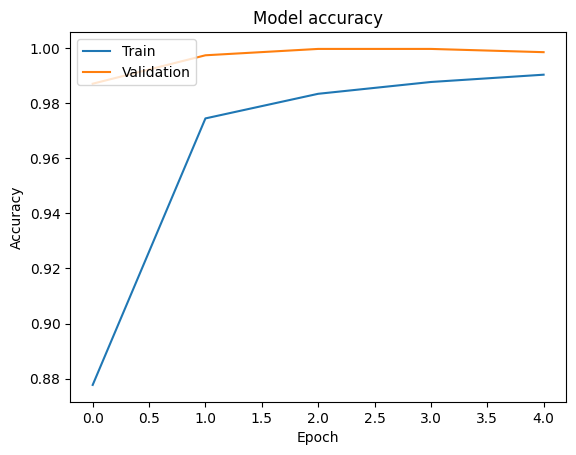

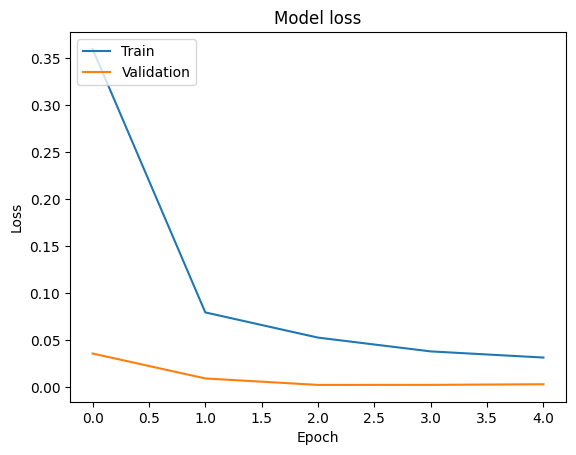

In [11]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()